# Movie for the ESSD paper

Includes demonstrations of how to calculate wind speed.

In [1]:
# data manipulation etc
import numpy as np
import xarray as xr
import copy
import pandas as pd
from scipy import stats

# OS interaction
import os

# DTS stuff
import pyfocs

# import plotting
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.dates import DateFormatter
from matplotlib.lines import Line2D

# Movie making
from moviepy.video.io.bindings import mplfig_to_npimage
import moviepy.editor as mpy
import proglog
proglog.notebook()

/Users/karllapo/anaconda3/lib/python3.8/abc.py:85: FutureWarning: xarray subclass DataStore should explicitly define __slots__
  cls = super().__new__(mcls, name, bases, namespace, **kwargs)


In [2]:
%matplotlib inline
# Higher resolution figures within the notebook
%config InlineBackend.figure_format = 'retina'

# Set the plot style from the seaborn library
sns.set_style("whitegrid")
context = 'paper'
sns.set_context(context)

# Define a default color palette (this should be fairly color blind friendly)
tol_bright = ['#4477AA', '#CCBB44', '#EE6677', '#228833', '#66CCEE', '#AA3377', '#BBBBBB']
sns.set_palette(sns.color_palette(tol_bright))

# 1. Data

## 1.1 Paths to data

In [3]:
# Assumes a particular relative location between the notebook and ESSD repository.
# Additionally, the Zendodo repository was locally organized into subdirectories.
# To run the notebook you will need to point these directories to where your data
# are located.
dir_notebook = os.getcwd()
os.chdir('../..')
dir_essd = os.getcwd()
dir_essd = os.path.join(dir_essd, 'love_dts/ESSD-repository')

# Met data
dir_csat_flux = os.path.join(dir_essd, 'CSAT fluxes')
dir_aws = os.path.join(dir_essd, 'AWS')

# Figures
dir_print = os.path.join(dir_essd, 'figures')

# DTS data
dir_ns = os.path.join(dir_essd, 'FODS', 'FODS-cross')
dir_oa = os.path.join(dir_essd, 'FODS', 'outer-array')
dir_heating = os.path.join(dir_essd, 'FODS', 'heating-rates')

## 1.2 CSAT

In [4]:
os.chdir(dir_csat_flux)
csat_1min = xr.open_dataset('LOVE19_CSAT_1min_fluxes.v2020-12-03.nc')
csat_names = ['0.5m', '1m', '4m', '12m']
csat_1min.coords['names'] = (('z'), csat_names)
csat_1min = csat_1min.swap_dims({'z': 'names'})

## 1.3 AWS

In [5]:
os.chdir(dir_aws)
aws = xr.open_dataset('AWS_Voi_1min.nc')

## 1.4 DTS Data

In [7]:
# North FODS-cross
# Heated stainless steel
ds_ns_hot = xr.open_mfdataset(
    os.path.join(
        dir_ns,
        'fods_cross_2019-07-22_0[2-5]*matr-inv_heated.nc'),
    combine='by_coords')
# Unheated stainless steel
ds_ns_cold = xr.open_mfdataset(
    os.path.join(
        dir_ns,
        'fods_cross_2019-07-22_0[2-5]*matr-inv_unheated.nc'),
    combine='by_coords')

# Outer array
# Twisted pair pvc
ds_p1 = xr.open_mfdataset(
    os.path.join(
        dir_oa,
        'outer_array_2019-07-22_0[2-5]*_matr-inv_p1.nc'),
    combine='by_coords')
# Heated stainless steel
ds_ss_hot = xr.open_mfdataset(
    os.path.join(
        dir_oa,
        'outer_array_2019-07-22_0[2-5]*_matr-inv_heated.nc'),
    combine='by_coords')
# Unheated stainless steel
ds_ss_cold = xr.open_mfdataset(
    os.path.join(
        dir_oa,
        'outer_array_2019-07-22_0[2-5]*matr-inv_unheated.nc'),
    combine='by_coords')

## 1.5 Heating rates

In [8]:
os.chdir(dir_heating)
# Open the estimated heating rates and assign to the "hot" dataset
ds_or_heat = xr.open_dataset('outer-rectangle_heating-rates.nc')
ds_ss_hot['power'] = ds_or_heat.outer_rectangle

# 2. Prepare data

## 2.1 Select just the period with the soliton

In [9]:
t1 = '2019-07-22 03:15:00'
t2 = '2019-07-22 03:55:00'
tslice = slice(t1, t2)

ds_p1 = ds_p1.sel(time=tslice).load()
ds_ss_hot = ds_ss_hot.sel(time=tslice).load()
ds_ss_cold = ds_ss_cold.sel(time=tslice).load()

ds_ns_hot = ds_ns_hot.sel(time=tslice).load()
ds_ns_cold = ds_ns_cold.sel(time=tslice).load()

## 2.2 Subselect the spatial data

Select out just the tower and the "mane", the transect that runs from north to south in the middle of the array that intersects with the tower.

In [10]:
ds_tower_cold = ds_ns_cold.where((ds_ns_cold.unheated == 'tower'), drop=True)
ds_tower_hot = ds_ns_hot.where((ds_ns_hot.heated == 'tower'), drop=True)

ds_mane = ds_ns_cold.where(
    (
        (ds_ns_cold.unheated == 'mane_south') | (ds_ns_cold.unheated == 'mane_north')
    ),
    drop=True
)
ds_mane = ds_mane.sortby(ds_mane.y)
ds_mane = ds_mane.reindex(time=ds_p1.time)

Combine all unheated fibers into a single Dataset.

In [11]:
# The coordinates "unheated" and "p1", which label the
# locations within the arrays, need to be dropped in order
# to concatenate the Datasets.
unheated = xr.concat(
    [
        ds_mane.drop_vars(['unheated']),
        ds_p1.drop_vars(['p1']),
        ds_ss_cold.drop_vars(['unheated'])
    ], 
    dim='xyz',
    coords='minimal'
)

# 3. Calculate Wind Speed

## 3.1 Tower wind speed

In [12]:
# Fiber properties

# Fiber radius in meters
rad = 1.32 / 2 * 10**(-3)

# Calculate the density
volume_per_m = rad ** 2 * np.pi * 1
kg_per_m = 5 / 1000
density = kg_per_m / volume_per_m
density_per_m_fiber = density * volume_per_m

# The estimate of the heating rate from the tower wind speed evaluation (see manuscript).
# In W/m
p = 4.5
params = {
    'rad': rad,
    'crv': 502, # Estimate from vR20. The storage term is small and plays a tertiary role.
    'density': density_per_m_fiber
}

# We need the AWS data to estimate the radiative fluxes
aws_sub = aws.reindex_like(ds_tower_cold.time, method='nearest')

tower_wind_speed  = pyfocs.wind_speed.calculate(
    ds_tower_hot.cal_temp + 273.15,
    ds_tower_cold.cal_temp + 273.15,
    p,
    (aws_sub['Rlwd (CNR4)'] + aws_sub['Rlwu (CNR4)']),
    method='vR20',
    params=params,
)

## 3.2 Outer array wind speed

Here we need to use the spatially varying estimate of the heating rate, as it is not uniform like for the tower.

In [13]:
# Fiber properties

# Fiber radius in meters
rad = 1.04 / 2 * 10**(-3)

# Calculate the fiber's density
volume_per_m = rad ** 2 * np.pi * 1
kg_per_m = 3 / 1000
density = kg_per_m / volume_per_m
density_per_m_fiber = density * volume_per_m

params = {
    'rad': rad,
    'crv': 502, # Estimate from vR20. The storage term is small and plays a tertiary role.
    'density': density_per_m_fiber
}

# As before, we need the radiative fluxes from the AWS
aws_sub = aws.reindex_like(ds_ss_hot.time, method='nearest')

oa_wind_speed = pyfocs.wind_speed.calculate(
    ds_ss_hot.cal_temp + 273.13,
    ds_ss_cold.cal_temp + 273.13,
    ds_ss_hot.power / 2,
    (aws_sub['Rlwd (CNR4)'] + aws_sub['Rlwu (CNR4)']),
    method='vR20',
    params=params
)

# Break into horizontal wind speed components, based on what
# direction is orthogonal to the fiber.
ns_components = ['OR_SE', 'OR_NW']
logic = [oa_wind_speed.unheated == l for l in ns_components]
logic = xr.concat(logic, dim='locations').any(dim='locations')
wind_speed_ns = oa_wind_speed.where(logic, drop=True)

ew_components = ['OR_SW2', 'OR_SW1', 'OR_NE1', 'OR_NE2']
logic = [oa_wind_speed.unheated == l for l in ew_components]
logic = xr.concat(logic, dim='locations').any(dim='locations')
wind_speed_ew = oa_wind_speed.where(logic, drop=True)

# 4 Create the movie

### Movie with all FODS combined into a single plot

Moviepy - Building video outerarray-combined-csat_190722-pre-mtp.v2-2021-06-21.mp4.
Moviepy - Writing video outerarray-combined-csat_190722-pre-mtp.v2-2021-06-21.mp4



t:   0%|          | 0/423 [00:00<?, ?it/s, now=None]

Moviepy - Done !
Moviepy - video ready outerarray-combined-csat_190722-pre-mtp.v2-2021-06-21.mp4


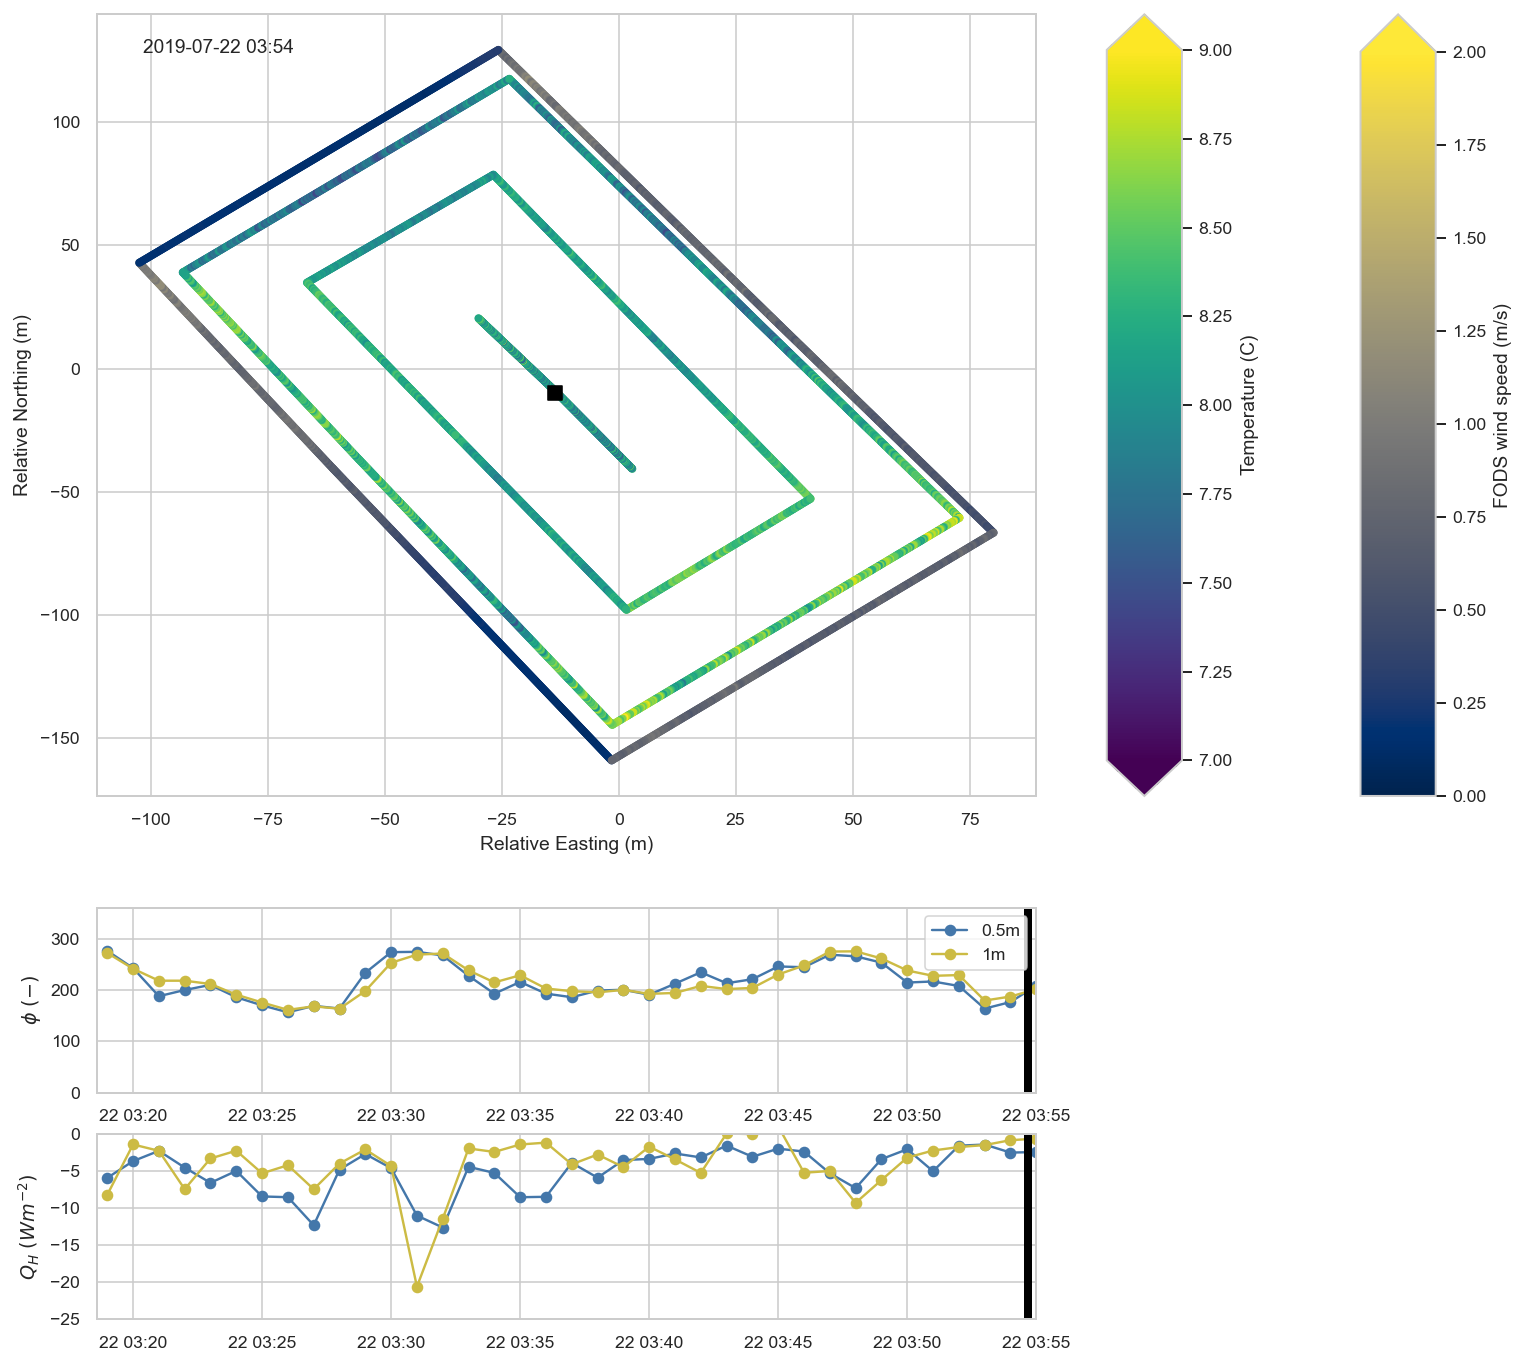

In [24]:
# =========================
t1 = '2019-07-22 03:31:28'
t2 = '2019-07-22 03:31:32'
temp = unheated.cal_temp.rolling(time=6, center=True).mean().dropna('time')
wind_ew = wind_speed_ew.rolling(time=6, center=True).mean().dropna('time')
wind_ns = wind_speed_ns.rolling(time=6, center=True).mean().dropna('time')
num_t = temp.time.size - 1
fps = 30
duration = num_t / fps
ds_csat = csat_1min.sel(time=slice(unheated.time[0], unheated.time[-1]))

# =========================
fig = plt.figure(figsize=(12, 12),)
spec = fig.add_gridspec(ncols=4,
                        nrows=5,
                        width_ratios=[1, 0.08, 0.04, 0.08],
                        height_ratios=[1, 1, 0.08, 0.5, 0.5],
                        hspace=0.18, wspace=0.25,
                        )
ax_ns_cbar = fig.add_subplot(spec[0:2, 3])
ax_t_cbar = fig.add_subplot(spec[0:2, 1])
ax_temp = fig.add_subplot(spec[0:2, 0])

ax_csat_dir = fig.add_subplot(spec[3, 0])
ax_csat_h = fig.add_subplot(spec[4, 0])

im_temp = ax_temp.scatter(
    unheated.x,
    unheated.y,
    s=10,
    c=unheated.sel(time=slice(t1, t2)).cal_temp.mean(dim='time').values,
    cmap='viridis',
    vmin=7.,
    vmax=9.,
)

ax_temp.set_ylabel('Relative Northing (m)')
ax_temp.set_xlabel('Relative Easting (m)')
plt.colorbar(im_temp, cax=ax_t_cbar, extend='both')
ax_t_cbar.set_ylabel('Temperature (C)')
time_value = np.datetime_as_string(unheated.time[0].values, unit='s')
ttl = ax_temp.text(0.05, 0.95, time_value, transform=ax_temp.transAxes)

im_wind_ew = ax_temp.scatter(
    wind_speed_ew.x * 1.1,
    wind_speed_ew.y * 1.1,
    s=10,
    c=wind_speed_ew.sel(time=slice(t1, t2)).mean(dim='time').values,
    cmap='cividis',
    vmin=0.,
    vmax=2.,
)

im_wind_ns = ax_temp.scatter(
    wind_speed_ns.x * 1.1,
    wind_speed_ns.y * 1.1,
    s=10,
    c=wind_speed_ns.sel(time=slice(t1, t2)).mean(dim='time').values,
    cmap='cividis',
    vmin=0.,
    vmax=2.,
)
plt.colorbar(im_wind_ns, cax=ax_ns_cbar, extend='max')
ax_ns_cbar.set_ylabel('FODS wind speed (m/s)')

# Indicate the tower's location.
ax_temp.scatter(-13.644, -9.787, 50, marker='s', color='0')

for n in ds_csat.names:
    if '12m' in n.values or '4m' in n.values:
        continue
    ax_csat_dir.plot(
        ds_csat.time,
        ds_csat['phi'].sel(names=n.names),
        '-o',
        label=n.values,
    )
    
ax_csat_dir.legend()
ax_csat_dir.set_ylim(0, 360)
ax_csat_dir.set_ylabel('$\phi~(-)$')
ax_csat_dir.set_xlim(unheated.time.values[0], unheated.time.values[-1])
dir_tline, = ax_csat_dir.plot(
    [
        unheated.time[0].values,
        unheated.time[0].values
    ],
    [0, 360],
    'k',
    linewidth=4,
)

for n in ds_csat.names:
    if '12m' in n.values or '4m' in n.values:
        continue
    ax_csat_h.plot(
        ds_csat.time,
        ds_csat['H'].sel(names=n.names),
        '-o',
        label=n.values,
    )

ax_csat_h.set_ylabel('$Q_H~(Wm^{-2})$')
ax_csat_h.set_xlim(unheated.time.values[0], unheated.time.values[-1])
ax_csat_h.set_ylim(-25, 0)
h_tline, = ax_csat_h.plot(
    [
        unheated.time[0].values,
        unheated.time[0].values
    ],
    [-25, 0],
    'k',
    linewidth=4,
)

# =========================
def make_frame(t):
    # Convert to a useful index for the data
    t = int(t * fps)
    colors_T = temp.isel(time=int(t)).values
    time_value = temp.time[t].values
    time_str = pd.Timestamp(time_value).strftime('%Y-%m-%d %H:%M')
    im_temp.set_array(colors_T)
    ttl.set_text(time_str)

    colors_ns = wind_ns.isel(time=int(t)).values
    im_wind_ns.set_array(colors_ns)

    colors_ew = wind_ew.isel(time=int(t)).values
    im_wind_ew.set_array(colors_ew)

    h_tline.set_xdata(time_value)
    dir_tline.set_xdata(time_value)
    
    return mplfig_to_npimage(fig)

os.chdir(dir_print)
animation = mpy.VideoClip(make_frame, duration=duration)
animation.write_videofile('outerarray-combined-csat_190722-pre-mtp.v2-2021-06-21.mp4', fps=fps)